# Understanding and Using BERT

we use as an interface: https://huggingface.co/transformers/

topics of this notebook:

* input tokenisation for Bert with transformers
* input format of BertModel (pretrained)
* using the output for word and sentence similarity

In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


# BERT = Bidirectional Encoder Representations from Transformers 

* trained on masked language learning at word and sentence level
* uses [CLS] and [SEP] as  segmentation markers
* uses subword representation 
* uses segmentation ids to indicate a words segment

* BERT is a context-aware word embedding (due to self attention and bi-directional encoding)
* word2vec is context independent

**procedure**





In [2]:
!pip install transformers

     |████████████████████████████████| 1.3MB 5.8MB/s 
     |████████████████████████████████| 1.1MB 44.5MB/s 
     |████████████████████████████████| 890kB 38.2MB/s 
     |████████████████████████████████| 2.9MB 42.7MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=9d097d244e15494938e6e6f2f7bf4b3957902b5ea8351b17f53df4c1c753e22a
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
from transformers import BertTokenizer, BertModel
import torch

MODEL_NAME = "bert-base-german-cased"   

tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

torch.set_grad_enabled(False) # torch vectors without grad

model = BertModel.from_pretrained(MODEL_NAME, output_hidden_states = True)

In [4]:
# example how to represent a single sentence in BERT

tokens = tokenizer.tokenize("Der Minister verliert die Geduld")
print("Tokens: {}".format(tokens))

# we map it to BERT indices
tokens_ids = tokenizer.convert_tokens_to_ids(tokens)
print("Tokens id: {}".format(tokens_ids))

# add the required special tokens
tokens_ids = tokenizer.build_inputs_with_special_tokens(tokens_ids)

# pytorch representation
tokens_pt = torch.tensor([tokens_ids])
print("Tokens PyTorch: {}".format(tokens_pt))

Tokens: ['Der', 'Minister', 'verliert', 'die', 'Ged', '##uld']
Tokens id: [233, 2475, 11864, 30, 3527, 13968]
Tokens PyTorch: tensor([[    3,   233,  2475, 11864,    30,  3527, 13968,     4]])


BERT uses the **word piece algorithm** to represent input words

* 3 = CLS, 4 = SEP
* ['Der', 'Minister', 'verliert', 'die', 'Ged', '##uld']
* '##uld' is a useful subword string, marked as such with '##'
* advantage: minimize out of vocabulary problem, less vocabulary size
* German compounds are no problem


word piece = language modelling task

* a language model is a probability distribution over sequences of words: P(w1, ... ,wn)

* vocabulary are all basic characters of the language (58 letters for German)
* generate new word pieces by combining pairs of pieces
* add those new pieces to the vocabulary that increase the language model’s likelihood on the training data the most
* do it untill the maximum vocabulary size is reached

In [5]:
# Multiple segment input
tokenized = tokenizer("Geduld", "Hoffnung",padding="max_length",max_length=9)

# Segments are concatened in the input to the model: CLS is beginning, SEP as separator
print()
print(" (str): {}".format(tokenizer.convert_ids_to_tokens(tokenized['input_ids'])))

# 
input_ids=torch.tensor([tokenized['input_ids']],dtype=torch.long)
segment_ids=torch.tensor([tokenized['token_type_ids']],dtype=torch.long)
input_mask=torch.tensor([tokenized['attention_mask']],dtype=torch.float)

# segment_ids separate different parts of the input
print("input_ids",input_ids)
print("segment_ids",segment_ids)
print("attention_mask",input_mask)



 (str): ['[CLS]', 'Ged', '##uld', '[SEP]', 'Hoffnung', '[SEP]', '[PAD]', '[PAD]', '[PAD]']
input_ids tensor([[    3,  3527, 13968,     4,  8772,     4,     0,     0,     0]])
segment_ids tensor([[0, 0, 0, 0, 1, 1, 0, 0, 0]])
attention_mask tensor([[1., 1., 1., 1., 1., 1., 0., 0., 0.]])


In [6]:
tokenized

{'input_ids': [3, 3527, 13968, 4, 8772, 4, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 1, 1, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 0, 0, 0]}

In [7]:
# BERT it, for output components see https://huggingface.co/transformers/model_doc/bert.html#bertmodel

(last_hidden_state,pooler_output,hidden_states)=model(input_ids,attention_mask=input_mask)
last_hidden_state.size(),type(hidden_states) 

(torch.Size([1, 9, 768]), tuple)

In [8]:
# we cannot get size of the hidden_states with size() since it is a tuple

print ("Number of layers:", len(hidden_states), "  (initial embeddings + 12 BERT layers)")
layer_i = 0
print ("Number of batches:", len(hidden_states[layer_i]))
batch_i = 0
print ("Number of tokens:", len(hidden_states[layer_i][batch_i]))
token_i = 0
print ("Number of hidden units:", len(hidden_states[layer_i][batch_i][token_i]))

Number of layers: 13   (initial embeddings + 12 BERT layers)
Number of batches: 1
Number of tokens: 9
Number of hidden units: 768


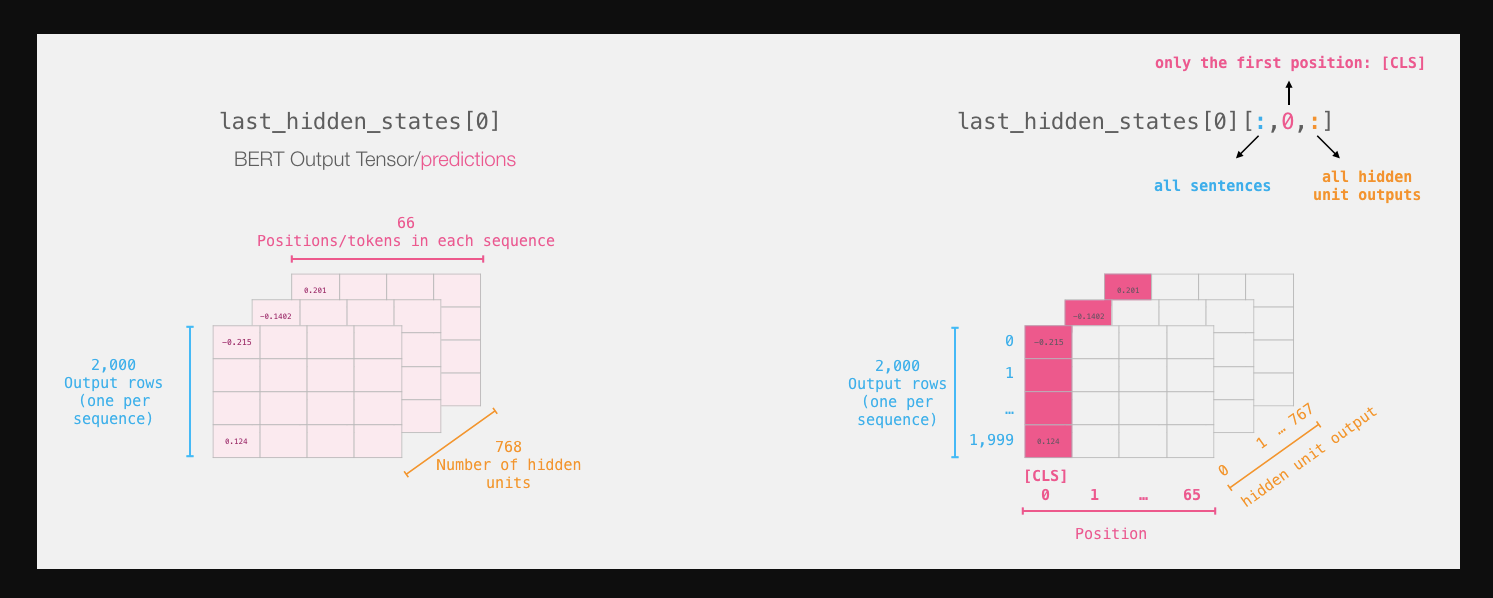

### what shall we do with output

* use it as input for some (non-)linear mappings
* use it as representation of the input
  * determine word similarity
  * determine sentence similarity

In [9]:
# word similarity: we use the sum of the last four layers 
#
# first, we re-arrange things a bit

# Concatenate the tensors for all layers (no longer a tuple)
token_embeddings = torch.stack(hidden_states, dim=0)
print(token_embeddings.size())

# get rid of the batch dimension
token_embeddings = torch.squeeze(token_embeddings, dim=1)
print(token_embeddings.size())

# re-arrange dimension
token_embeddings = token_embeddings.permute(1,0,2)
token_embeddings.size()

torch.Size([13, 1, 9, 768])
torch.Size([13, 9, 768])


torch.Size([9, 13, 768])

In [11]:
# word embeddings from last 4 layers

def Bert_word_representation(hidden_states):

  token_embeddings = torch.stack(hidden_states, dim=0)
  token_embeddings = torch.squeeze(token_embeddings, dim=1)
  token_embeddings = token_embeddings.permute(1,0,2)

  token_vecs_sum=[]
  for token in token_embeddings:
    # sum the vectors from the last four layers.
    sum_vec = torch.sum(token[-4:], dim=0)
    
    # use `sum_vec` to represent `token`.
    token_vecs_sum.append(sum_vec)
  return token_vecs_sum

In [12]:
def bertify(input):

  tokenized = tokenizer(input,return_tensors='pt',padding="max_length",max_length=20,truncation=True)

  input_ids=tokenized['input_ids']
  #segment_ids=tokenized['token_type_ids']
  input_mask=tokenized['attention_mask']
  return input_ids,input_mask

input="Er beraubt eine Bank , geht in den Park und setzt sich auf eine Bank"

input_ids,input_mask=bertify(input)

outputs=model(input_ids,attention_mask=input_mask)

token_vecs_sum=Bert_word_representation(outputs[2])  # the hidden states
len(token_vecs_sum)

20

In [13]:
from scipy.spatial.distance import cosine

sim1 = 1 - cosine(token_vecs_sum[6], token_vecs_sum[17])
sim2 = 1 - cosine(token_vecs_sum[6], token_vecs_sum[11])
sim3 = 1 - cosine(token_vecs_sum[11], token_vecs_sum[17])

print(" (str): {}".format(tokenizer.convert_ids_to_tokens(input_ids.squeeze(dim=0))))


print('Vector similarity:  %.2f' % sim1)
print('Vector similarity :  %.2f' % sim2)
print('Vector similarity :  %.2f' % sim3)


 (str): ['[CLS]', 'Er', 'ber', '##aub', '##t', 'eine', 'Bank', ',', 'geht', 'in', 'den', 'Park', 'und', 'setzt', 'sich', 'auf', 'eine', 'Bank', '[SEP]', '[PAD]']
Vector similarity:  0.82
Vector similarity :  0.68
Vector similarity :  0.63


not ideal: which index to take, if the word was splitted? Well, we have to somehow combine the parts, e.g. by summing their vectors

### sentence similarity

various strategies:

* take the mean of some of the word layers
* take the final hidden state of CLS

see https://mccormickml.com/2019/05/14/BERT-word-embeddings-tutorial/



In [14]:
# sentence representation: mean of last 4 layers

input="Die Sonne scheint und die Welt gibt Gas"
input2="Der Bauer schleicht zur Mühle und gibt sich Mühe"

def sentence_emb(input):
  input_ids,input_mask=bertify(input)
  outputs=model(input_ids,attention_mask=input_mask)
  hidden_states=outputs[2]
  token_vecs = hidden_states[-4][0]  
  sentence_embedding = torch.mean(token_vecs, dim=0)
  return sentence_embedding

sentence_embedding1 = sentence_emb(input)
sentence_embedding2 = sentence_emb(input2)

1 - cosine(sentence_embedding1,sentence_embedding2)

0.8995559215545654

In [15]:
# sentence representation: CLS at last layer

def sentence_embCLS(input):
  input_ids,input_mask=bertify(input)
  (last_hidden_state,_,_)=model(input_ids,attention_mask=input_mask)
  return   last_hidden_state[:,0,:]   # take in dimension 2 the first entry (CLS)

sentence_embedding1 = sentence_embCLS(input)
sentence_embedding2 = sentence_embCLS(input2)

1 - cosine(sentence_embedding1,sentence_embedding2)

0.7757149338722229

### summary

* we know how to tokenizer for BERT
* we know how to apply a pretained model to some input
* we know how the output is structured 
* we know how we can derived word and sentence representations from it

* next step: retrain BERT (transfer learning)
